In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import precision_recall_curve

In [2]:
# Load the dataset.
data2 = pd.read_csv("C:\\Users\\anne\\Desktop\\Daki\\s1\\projekter\\P1\\mri_data_P1\\oasis_longitudinal.csv")

# Data preprocessing.
print(data2.info())

# Encode categorical variables.
data2['Group'] = data2['Group'].replace({'Converted': 1, 'Demented': 2, 'Nondemented': 0})

# Remove irrelevant data.
data2 = data2[data2['Group'] != 2]  # Remove Demented.
data2 = data2[~((data2['Group'] == 1) & (data2['CDR'] > 0.5))]  # Remove Converted with CDR > 0.5.

data2 = data2.drop(['MRI ID', 'Visit', 'Hand', 'CDR'], axis=1)

# Impute missing values with median.
imputer = SimpleImputer(strategy='median')
data2[['SES', 'MMSE']] = imputer.fit_transform(data2[['SES', 'MMSE']])

# Separate features and target. SubjectID is dropped of object.
X = data2.drop(columns=['Group', 'Subject ID'])
y = data2['Group']

# Apply one-hot encoding for categorical variables.
X = pd.get_dummies(X, columns=['M/F'], drop_first=True)

# Apply standard scaling.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the classes.
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_scaled, y_resampled = smote.fit_resample(X_scaled, y)

# Check class distribution after SMOTE.
print(f"Class distribution after SMOTE: {np.unique(y_resampled, return_counts=True)}")

# Split the data.
X_scaled_temp, X_scaled_test, y_temp, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)
X_scaled_train, X_scaled_val, y_train, y_val = train_test_split(X_scaled_temp, y_temp, test_size=0.125, random_state=42)

# Define the XGBoost model.
xgb_model = XGBClassifier(random_state=42, n_estimators=1000, learning_rate=0.1, eval_metric='logloss')

# Set up hyperparameters for GridSearchCV.
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "max_depth": [3, 5, 8, 10],
    "n_estimators": range(100, 500, 1000),
}

# Perform GridSearchCV with Cross-Validation.
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                           scoring='accuracy', n_jobs=-1)

grid_search.fit(X_scaled_train, y_train)

# Get the best parameters and the best model.
print("Best hyperparameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the best model on the validation and test sets.
y_pred = best_model.predict(X_scaled_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")
print(classification_report(y_val, y_pred))

y_test_pred = best_model.predict(X_scaled_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(classification_report(y_test, y_test_pred))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB
None
Class distribution after SMOTE: (array([0, 1]), array([190, 190]))


C:\Users\anne\AppData\Local\Temp\ipykernel_21936\786352972.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data2['Group'] = data2['Group'].replace({'Converted': 1, 'Demented': 2, 'Nondemented': 0})


Best hyperparameters found:  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}
Validation Accuracy: 0.9210526315789473
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.90      0.95      0.92        19

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38

Test Accuracy: 0.8947368421052632
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        38
           1       0.92      0.87      0.89        38

    accuracy                           0.89        76
   macro avg       0.90      0.89      0.89        76
weighted avg       0.90      0.89      0.89        76



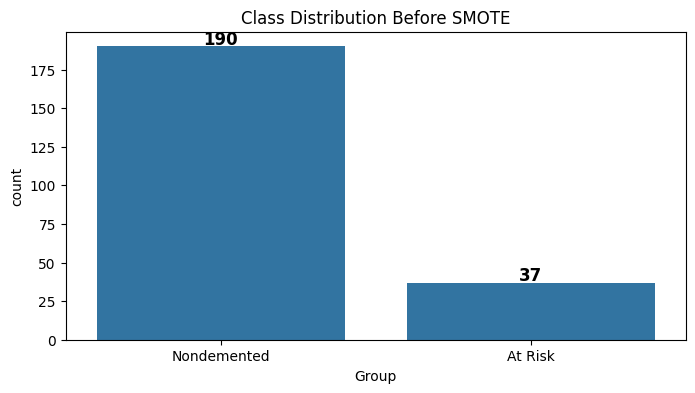

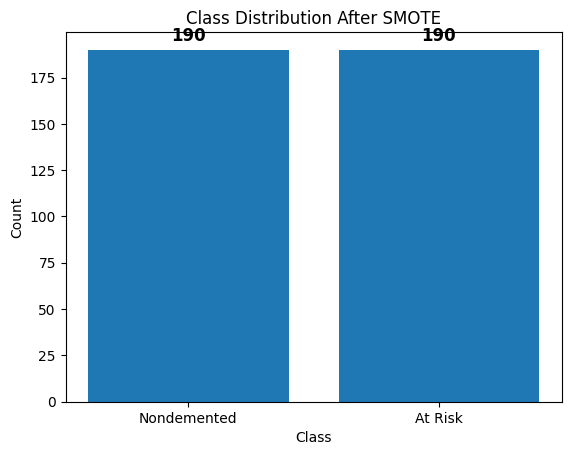

In [3]:
# Before SMOTE.
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='Group', data=data2)
plt.xticks(ticks=[0, 1], labels=["Nondemented", "At Risk"])
plt.title("Class Distribution Before SMOTE")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', fontweight='bold', 
                xytext=(0, 5), textcoords='offset points')

plt.show()

# After SMOTE.
unique, counts = np.unique(y_resampled, return_counts=True)
plt.bar(unique, counts, tick_label=["Nondemented", "At Risk"])
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
for i, v in enumerate(counts):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12, fontweight='bold')
plt.show()

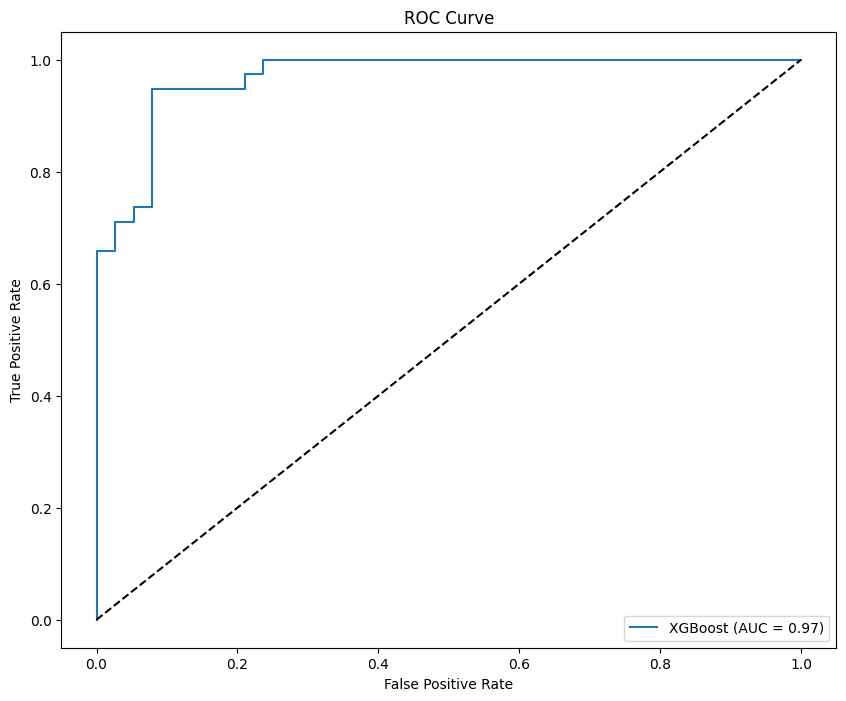

In [4]:
# ROC Curve and AUC.
roc_values = {
    'XGBoost': best_model.predict_proba(X_scaled_test)[:, 1]
}

plt.figure(figsize=(10, 8))
for model_name, y_pred_proba in roc_values.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

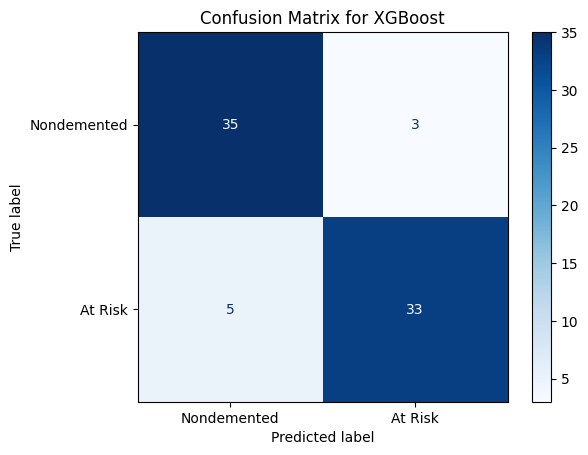

c:\Users\anne\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:06:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\anne\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:06:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\anne\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:06:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

In [5]:
# Predictions on the test set.
y_test_pred = best_model.predict(X_scaled_test)

# Compute confusion matrix.
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Nondemented", "At Risk"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBoost')
plt.show()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
auc_scores = []

for train_index, test_index in skf.split(X_scaled, y_resampled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    # Evaluate on test fold.
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    cv_results.append(accuracy)

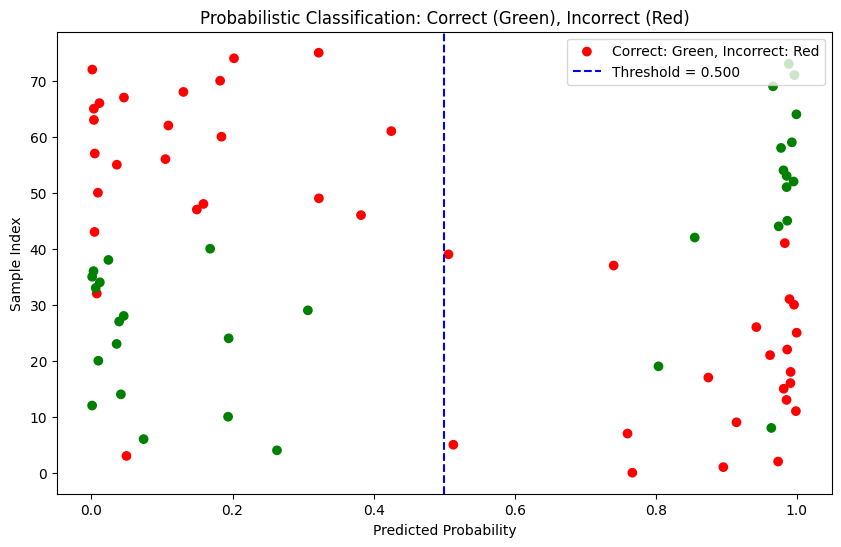

In [6]:
# Predict probabilities for the positive class (default threshold 0.5).
y_probs = best_model.predict_proba(X_scaled_test)[:, 1]

# Default threshold for binary classification.
threshold = 0.5
y_pred_default = (y_probs > threshold).astype(int)

# Reset index to avoid KeyError.
y_test_reset = y_test.reset_index(drop=True)

# Create a scatter plot to visualize correct and incorrect classifications.
plt.figure(figsize=(10, 6))
colors = ['green' if y_test_reset[i] == y_pred_default[i] else 'red' for i in range(len(y_test_reset))]

plt.scatter(y_probs, np.arange(len(y_probs)), c=colors, label='Correct: Green, Incorrect: Red')
plt.axvline(x=threshold, color='blue', linestyle='--', label=f'Threshold = {threshold:.3f}')
plt.xlabel('Predicted Probability')
plt.ylabel('Sample Index')
plt.title('Probabilistic Classification: Correct (Green), Incorrect (Red)')
plt.legend()
plt.show()